# CNN
This notebook will briefly introduce and explore advantages of convolutional layers over MLPs in image classification.

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
import torch
import numpy as np
import random
import os

def set_pytorch_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [17]:
data = d2l.FashionMNIST(batch_size=128)

In [18]:
def evaluate_model(model, data_loader):
    metric = d2l.Accumulator(2)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_hat = model(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

In [19]:
def init_cnn(module): 
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

## Shift Invariance
A major limitation to MLPs with image classification is that real images have some shifts within them, but we wouldn't consider the image classification to change. For example, let's consider the visualization of some images of the dataset when they are shifted to the right by two.

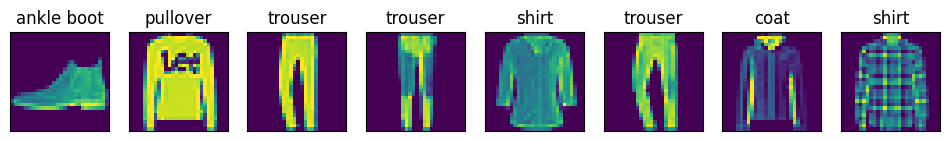

In [29]:
data.visualize(next(iter(data.val_dataloader())))

In [37]:
from torchvision import transforms
import torch.nn.functional as F 

data_shifted = d2l.FashionMNIST(batch_size=128)

# Define the shift logic as a function
# Note: Transforms usually receive (C, H, W), so padding is applied to the last dim
def shift_down_transform(img_tensor):
    y = 2
    padded = F.pad(img_tensor, (0, 0, y, 0)) 
    return padded[:, :-y, :]

# Apply this to your dataset
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(shift_down_transform)
])

# Manually inject the transform into the existing validation dataset
data_shifted.val_dataloader().dataset.transform = transform_pipeline

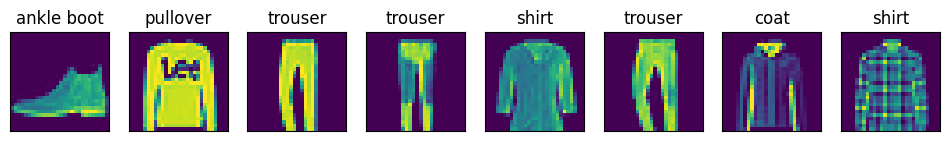

In [38]:
data_shifted.visualize(next(iter(data_shifted.val_dataloader())))

As humans, we know that the boot is still a boot whether it is shifted down two pixels or not. However, the MLP will treat the shifted boot differently from the original boot image, because the MLP classification process unrolled the 2D image data into a 1D tensor. There was no understanding of positional invariance. Let's train a standard MLP and see this in action.

In [62]:
class MLP(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.hidden = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden_out = self.hidden(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

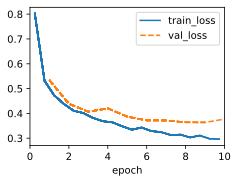

In [65]:
mlp = MLP(hidden_layers=(128,64))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
mlp.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp.apply(init_cnn)
trainer.fit(mlp, data)

In [66]:
acc = evaluate_model(mlp, data.val_dataloader())
print("Final val accuracy on original data:", acc)
accs = evaluate_model(mlp, data_shifted.val_dataloader())
print("Final val accuracy on shifted data:", accs)

Final val accuracy on original data: 0.8573
Final val accuracy on shifted data: 0.7172


As seen, the model performance drops significantly as we evaluate the trained model on test images shifted down even just 2 pixels. We want our models to be shift invariant for multiple reasons. First, we see here that trained models need to generalize well to unseen test images that may be shifted. Second, if our training data also contains shifted patterns, then the network will struggle to learn without a shift invariant algorithm. The convolutional layer is one way that we can capture information in a shift invariant manner.

In [53]:
class CNN(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
        )
        self.ff = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = self.net(x)
        hidden_out = self.ff(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

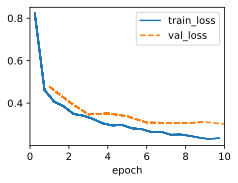

In [67]:
cnn = CNN(hidden_layers=(128,64))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
cnn.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
cnn.apply(init_cnn)
trainer.fit(cnn, data)

In [68]:
cnnacc = evaluate_model(cnn, data.val_dataloader())
print("Final val accuracy on original data:", cnnacc)
cnnaccs = evaluate_model(cnn, data_shifted.val_dataloader())
print("Final val accuracy on shifted data:", cnnaccs)

Final val accuracy on original data: 0.8894
Final val accuracy on shifted data: 0.7882


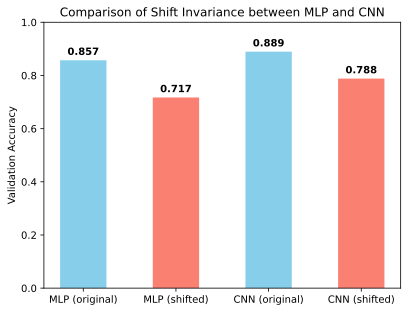

In [70]:
import matplotlib.pyplot as plt

# Define the models and their corresponding accuracies
models = ['MLP (original)', 'MLP (shifted)', 'CNN (original)', 'CNN (shifted)']
accuracies = [acc, accs, cnnacc, cnnaccs]  # Example validation accuracies

# Create the bar chart
plt.bar(models, accuracies, color=['skyblue', 'salmon'], width=0.5)

# Add labels and title
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Shift Invariance between MLP and CNN')

# Set y-axis limit (0 to 1 for accuracy)
plt.ylim(0, 1.0)

# Optional: Add the specific accuracy values on top of each bar
for i, val in enumerate(accuracies):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', fontweight='bold')

# Save and show the plot
plt.show()

As seen, the network with the convolution layer maintains performance when the data is shifted and would be considered more "shift invariant" than the MLP. However, we still observe notable drop in performance, because the model is not being trained on the shifted data and we are naively testing covariate shift effects as well. Regardless, there is some shift invariance observed when the CNN maintains better performance on shifted test data. 

It is interesting to also see that the CNN performs better than the MLP on the non-shifted data. Here, covariate shifts are not observed, so benefits are likely a result of a larger network or the shift invariance supporting better training of the data that has some shifts between samples.

Even with this very simple CNN, we see how the shift invariance property lends well to image tasks for both traiing and generalization purposes. The switch from MLP to CNN did not introduce major limitations different from MLPs. This finding is consistent with the theoretical understanding that convolutional layers act as scanning MLPs. Scanning MLPs meaning MLPs that scan crops of the image across the entire image with the same MLP parameters.

## Convolution Size and the Receptive Field
The kernel size of a convolutional layer determines how much of the cropped image we compute the convolution over for each output of the convolutional layer. The input space over which each convolution output is computed from is also known as the receptive layer.

An absurdly large convolutional layer will compute over the whole image to produce one output (per channel). Whereas an absurdly small convolution might only look at one pixel at a time. On one hand, we want a large receptive field to capture patterns that are large and not simply pass too-granular information to subsequent layers, but a receptive field that is too large may lose important signals that require that granularity.

Let's experiment with a hypothesis that the ideal kernel size lies between these two extremes.

In [ ]:
class CNN_convsizes(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,), kernel_size=7):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=kernel_size, padding=(kernel_size-1)//2), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
        )
        self.ff = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = self.net(x)
        hidden_out = self.ff(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

Conv size 21 - Val acc original: 0.8753


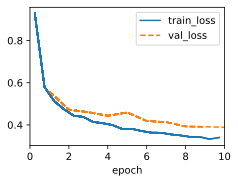

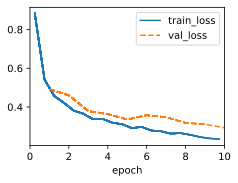

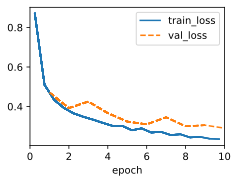

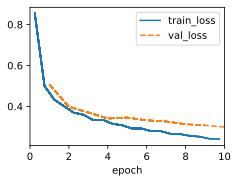

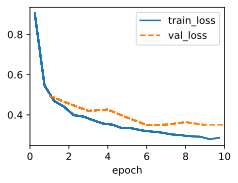

In [74]:
convsizes = [1, 3, 7, 13, 21]
acc_results = {}

for s in convsizes:
    print(f"Training CNN with conv size {s}")
    cnn = CNN_convsizes(hidden_layers=(128,64), kernel_size=s)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    cnn.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    cnn.apply(init_cnn)
    trainer.fit(cnn, data)
    cnnacc = evaluate_model(cnn, data.val_dataloader())
    print(f"Conv size {s} - Val acc original: {cnnacc}")
    acc_results[s] = cnnacc

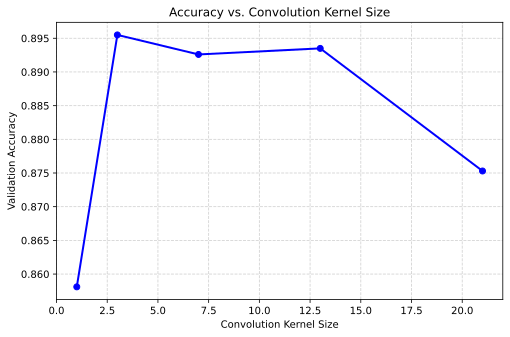

In [77]:
import matplotlib.pyplot as plt

data_dict = acc_results

# Extract and sort keys numerically if they represent numbers
# This ensures the line graph flows correctly from left to right
sorted_keys = sorted(data_dict.keys(), key=lambda x: float(x))
values = [data_dict[k] for k in sorted_keys]

# Create the line graph
plt.figure(figsize=(8, 5))
plt.plot(sorted_keys, values, marker='o', linestyle='-', color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Convolution Kernel Size')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
plt.show()

As expected, there is some maximum between the very small and very large receptive field that leads to the best performing CNN. For our dataset, the optimum is around 3, which means notable signals are around that 3x3 pixel size.

## Distributed Scanning
As above, the size of the convolutional layer matters for the model performance, because the receptive field should match the size of meaningful signals. However, it is impractical to always train model architectures in this manner. Instead, we can take advantage of multiple smaller convolutional layers to emulate a larger receptive field without the drawbacks. By splitting up the convolutions in multiple layers, we create distributed scanning of the images.

Distributed scanning allows the first convolution receptive field to be small and granular while allowing later convolutional layers to learn larger patterns.

The following CNN has the same receptive field in the second convolutional layer as the largest convolution of the previous experiment.

In [79]:
class CNN_distributed(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(128,64)):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=11, padding=5), nn.ReLU(),
            nn.LazyConv2d(6, kernel_size=11, padding=5), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
        )
        self.ff = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = self.net(x)
        hidden_out = self.ff(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

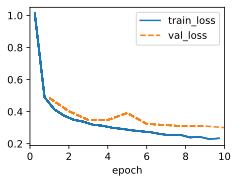

In [80]:
cnn = CNN_distributed()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
cnn.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
cnn.apply(init_cnn)
trainer.fit(cnn, data)

In [81]:
cnnacc = evaluate_model(cnn, data.val_dataloader())
print("Final val accuracy on original data:", cnnacc)

Final val accuracy on original data: 0.8886


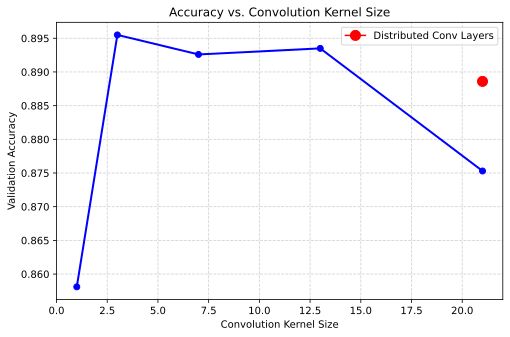

In [85]:
import matplotlib.pyplot as plt

data_dict = acc_results

# Extract and sort keys numerically if they represent numbers
# This ensures the line graph flows correctly from left to right
sorted_keys = sorted(data_dict.keys(), key=lambda x: float(x))
values = [data_dict[k] for k in sorted_keys]

# Create the line graph
plt.figure(figsize=(8, 5))
plt.plot(sorted_keys, values, marker='o', linestyle='-', color='blue', linewidth=2)
plt.plot([21], [cnnacc], marker='o', color='red', markersize=10, label='Distributed Conv Layers')
plt.legend()

# Adding labels and title
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Convolution Kernel Size')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
plt.show()

As seen, distributed convolutions allows building of networks with large receptive field convolutional layers while still maintaining granular signals within the dataset. Stacking convolutional layers becomes an effective strategy to merge the benefits of a small and large convolutional kernel size.